# Housekeeping (Importing libraries, loading datasets)

In [1]:
from utility import random_number_generator as rng
from utility import variance_reduction as vr

import pandas as pd
import numpy as np
from datetime import datetime
import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
from scipy.stats import norm

### SOFR Data Work

In [2]:
# secured overnight financing rate, sourced from the st. louis fred
sofr = pd.read_csv('data/FRED_SOFR.csv', parse_dates=['DATE'], index_col='DATE')

In [3]:
sofr.head()

,SOFR
DATE,
2018-04-03,1.83
2018-04-04,1.74
2018-04-05,1.75
2018-04-06,1.75
2018-04-09,1.75


In [4]:
print(sofr.info())
print(sofr.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1719 entries, 2018-04-03 to 2024-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SOFR    1719 non-null   object
dtypes: object(1)
memory usage: 26.9+ KB
None
            SOFR
DATE            
2018-04-03  1.83
2018-04-04  1.74
2018-04-05  1.75
2018-04-06  1.75
2018-04-09  1.75


In [5]:
# Ensure the SOFR column is numeric
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')  # Convert to numeric, set invalid entries to NaN

# Drop rows with NaN values in the SOFR column
sofr.dropna(subset=['SOFR'], inplace=True)

# Convert to decimal format (from percentages)
sofr['Rate'] = sofr['SOFR'] / 100

In [6]:
print(sofr.head())

            SOFR    Rate
DATE                    
2018-04-03  1.83  0.0183
2018-04-04  1.74  0.0174
2018-04-05  1.75  0.0175
2018-04-06  1.75  0.0175
2018-04-09  1.75  0.0175


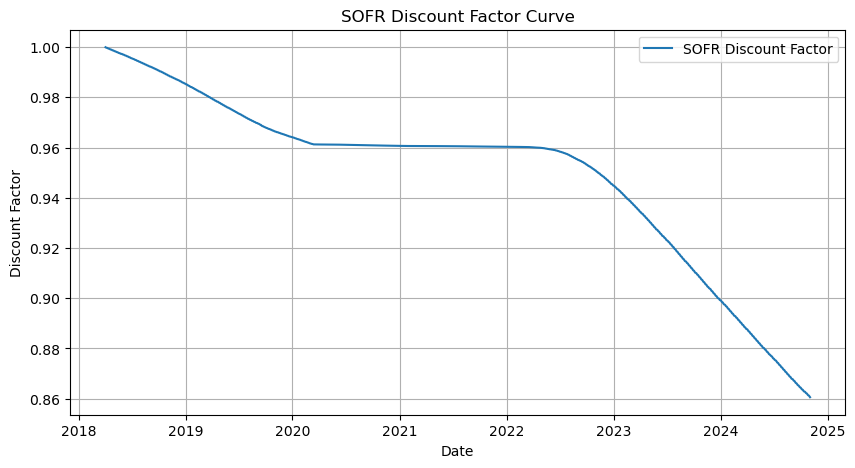

In [7]:
sofr['Rate'] = sofr['SOFR'] / 100  # Convert to decimal format

# Compute cumulative discount factors
dt = 1 / 252  # Daily time step
sofr['Discount_Factor'] = np.exp(-np.cumsum(sofr['Rate'] * dt))

# Plot the SOFR discount factor curve
plt.figure(figsize=(10, 5))
plt.plot(sofr.index, sofr['Discount_Factor'], label="SOFR Discount Factor")
plt.title("SOFR Discount Factor Curve")
plt.xlabel("Date")
plt.ylabel("Discount Factor")
plt.legend()
plt.grid()
plt.show()

### Market Yield Data Work

In [8]:
# Load Market Yield on U.S. Treasury Securities at X-Year Constant Maturity, Quoted on an Investment Basis
dgs1 = pd.read_csv('data/DGS1.csv', parse_dates=['DATE'], index_col='DATE')
dgs2 = pd.read_csv('data/DGS2.csv', parse_dates=['DATE'], index_col='DATE')
dgs5 = pd.read_csv('data/DGS5.csv', parse_dates=['DATE'], index_col='DATE')
dgs10 = pd.read_csv('data/DGS10.csv', parse_dates=['DATE'], index_col='DATE')
dgs30 = pd.read_csv('data/DGS30.csv', parse_dates=['DATE'], index_col='DATE')

# combine them all
yc = pd.concat([dgs1.rename(columns={'DGS1': '1Y'}),
                              dgs2.rename(columns={'DGS2': '2Y'}),
                              dgs5.rename(columns={'DGS5': '5Y'}),
                              dgs10.rename(columns={'DGS10': '10Y'}),
                              dgs30.rename(columns={'DGS30': '30Y'})], axis=1)

# I. Exploratory Data Analysis

In [9]:
# check formissing values and prepare for imputation
print("\nMissing values in SOFR Data:", sofr.isna().sum())
print("Missing values in Yield Curve Data:", yc.isna().sum())


Missing values in SOFR Data: SOFR               0
Rate               0
Discount_Factor    0
dtype: int64
Missing values in Yield Curve Data: 1Y        0
2Y     3760
5Y        0
10Y       0
30Y    3945
dtype: int64


In [10]:
print("\nSOFR Summary Statistics:")
print(sofr.describe())


SOFR Summary Statistics:
              SOFR         Rate  Discount_Factor
count  1647.000000  1647.000000      1647.000000
mean      2.297535     0.022975         0.949605
std       2.014423     0.020144         0.033830
min       0.010000     0.000100         0.860570
25%       0.090000     0.000900         0.936837
50%       1.950000     0.019500         0.960496
75%       4.550000     0.045500         0.965557
max       5.400000     0.054000         0.999927


In [11]:
print("\nYield Curve Summary Statistics:")
print(yc.describe())


Yield Curve Summary Statistics:
           1Y     2Y     5Y    10Y    30Y
count   16393  12633  16393  16393  12448
unique   1896   1873   1468   1403   1323
top         .      .      .      .      .
freq      698    530    698    698    523


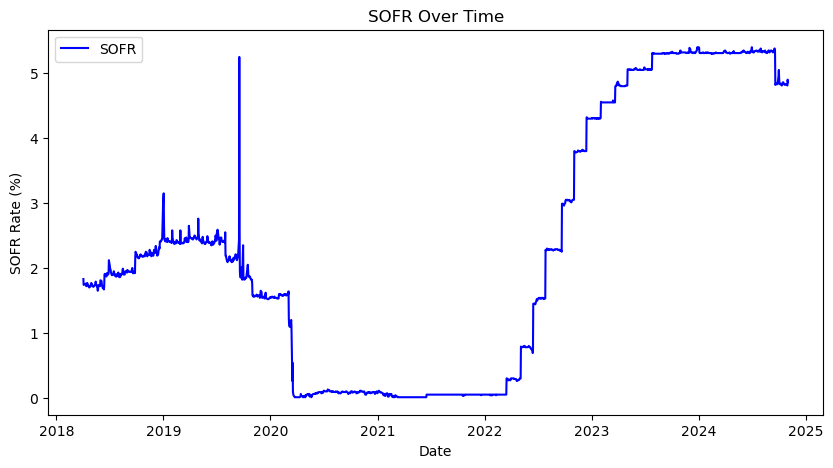

In [12]:
# Ensure SOFR data is numeric and drop any non-numeric rows (if any)
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna()  # Drop rows where SOFR might be NaN after conversion

# Plot SOFR over time
plt.figure(figsize=(10, 5))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='blue')
plt.title("SOFR Over Time")
plt.xlabel("Date")
plt.ylabel("SOFR Rate (%)")
plt.legend()
plt.show()

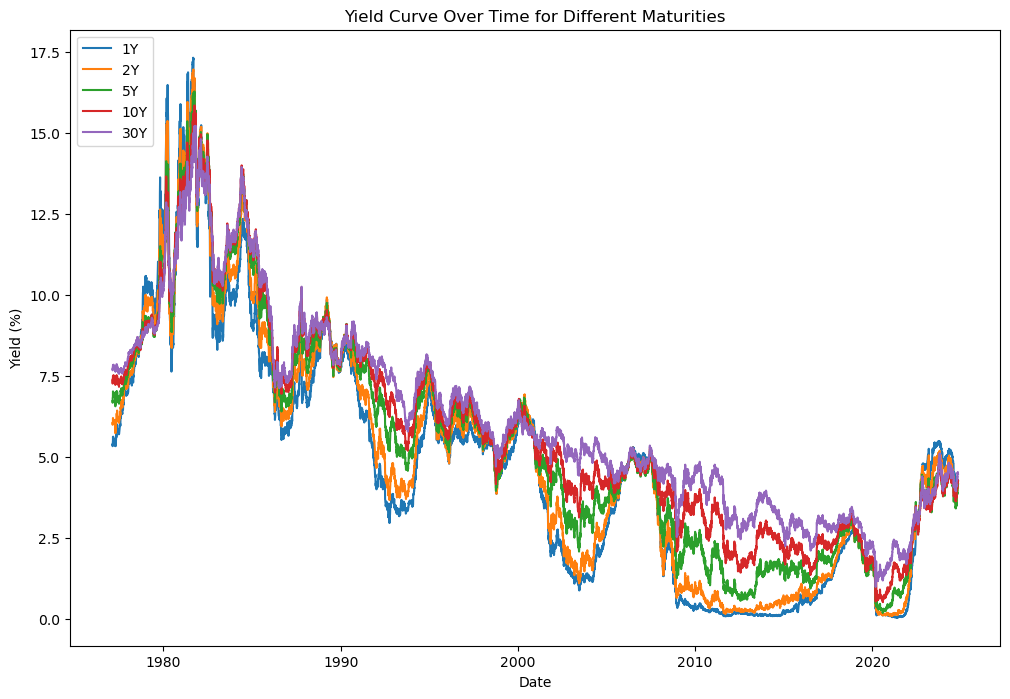

In [13]:
# Ensure all yield curve columns are numeric and handle any non-numeric values
for col in yc.columns:
    yc[col] = pd.to_numeric(yc[col], errors='coerce')

yc = yc.interpolate(method='time').dropna()  # Interpolate missing values based on time index

plt.figure(figsize=(12, 8))
for col in yc.columns:
    plt.plot(yc.index, yc[col], label=col)
    
plt.title("Yield Curve Over Time for Different Maturities")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend(loc='upper left')
plt.show()

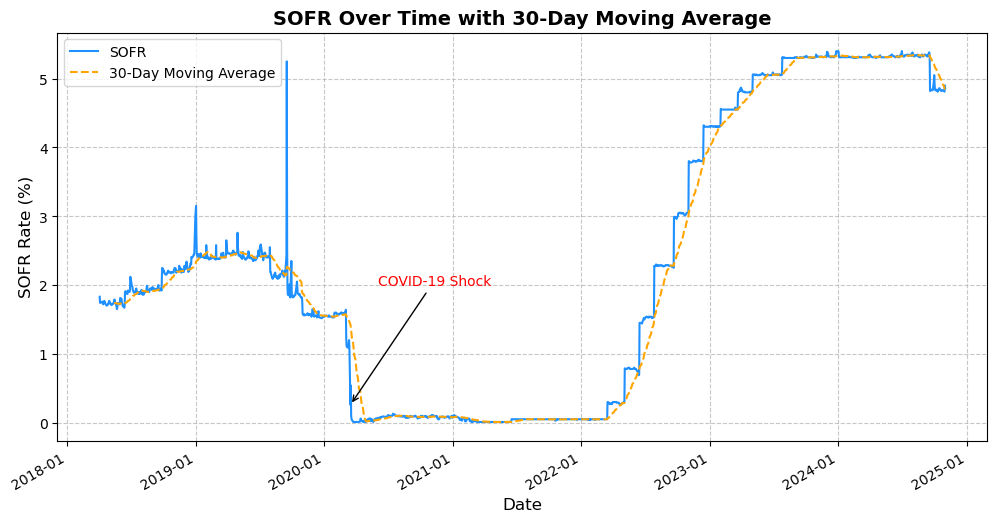

In [14]:
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna() 

sofr['SOFR_MA'] = sofr['SOFR'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='dodgerblue')
plt.plot(sofr.index, sofr['SOFR_MA'], label='30-Day Moving Average', color='orange', linestyle='--')
annot_date = datetime(2020, 3, 16)
plt.annotate('COVID-19 Shock', 
             xy=(annot_date, sofr.loc[annot_date, 'SOFR']), 
             xytext=(datetime(2020, 6, 1), 2.0),
             arrowprops=dict(facecolor='red', arrowstyle='->'), color='red')

plt.title("SOFR Over Time with 30-Day Moving Average", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("SOFR Rate (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

plt.show()

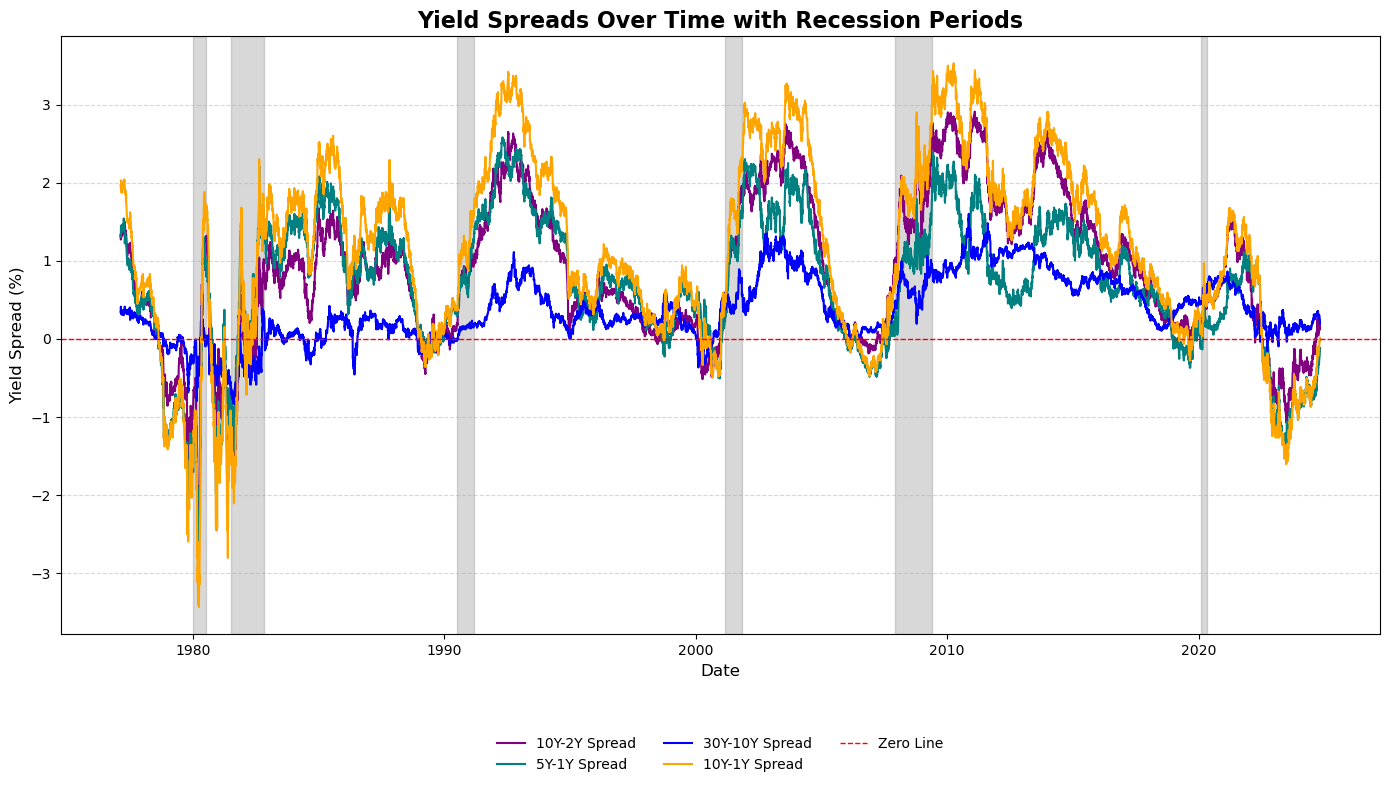

In [15]:
recession_periods = [
    ('1969-12-01', '1970-11-01'),
    ('1973-11-01', '1975-03-01'),
    ('1980-01-01', '1980-07-01'),
    ('1981-07-01', '1982-11-01'),
    ('1990-07-01', '1991-03-01'),
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-05-01') 
]

start_date = '1975-01-01'
filtered_yc = yc[yc.index >= start_date]
filtered_yc['10Y-2Y Spread'] = filtered_yc['10Y'] - filtered_yc['2Y']
filtered_yc['5Y-1Y Spread'] = filtered_yc['5Y'] - filtered_yc['1Y']
filtered_yc['30Y-10Y Spread'] = filtered_yc['30Y'] - filtered_yc['10Y']
filtered_yc['10Y-1Y Spread'] = filtered_yc['10Y'] - filtered_yc['1Y']

plt.figure(figsize=(14, 8))
plt.plot(filtered_yc.index, filtered_yc['10Y-2Y Spread'], color='purple', label='10Y-2Y Spread')
plt.plot(filtered_yc.index, filtered_yc['5Y-1Y Spread'], color='teal', label='5Y-1Y Spread')
plt.plot(filtered_yc.index, filtered_yc['30Y-10Y Spread'], color='blue', label='30Y-10Y Spread')
plt.plot(filtered_yc.index, filtered_yc['10Y-1Y Spread'], color='orange', label='10Y-1Y Spread')

plt.axhline(0, color='red', linestyle='--', label='Zero Line', linewidth=1)

for start, end in recession_periods:
    if start >= start_date: 
        plt.axvspan(start, end, color='gray', alpha=0.3)

plt.title("Yield Spreads Over Time with Recession Periods", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Yield Spread (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

are all these spreads required to be plotted? whats the significance?

# II: Construction of Forward Rate Curves

Forward Rate Curve:
               1Y-2Y     2Y-5Y    5Y-10Y   10Y-30Y
DATE                                              
1977-02-15  6.694009  7.175754  8.003838  7.870404
1977-02-16  6.643647  7.155755  7.983839  7.835380
1977-02-17  6.654136  7.125755  7.853263  7.875587
1977-02-18  6.744388  7.329690  8.003259  7.935427
1977-02-21  6.728915  7.339630  8.003176  7.942927


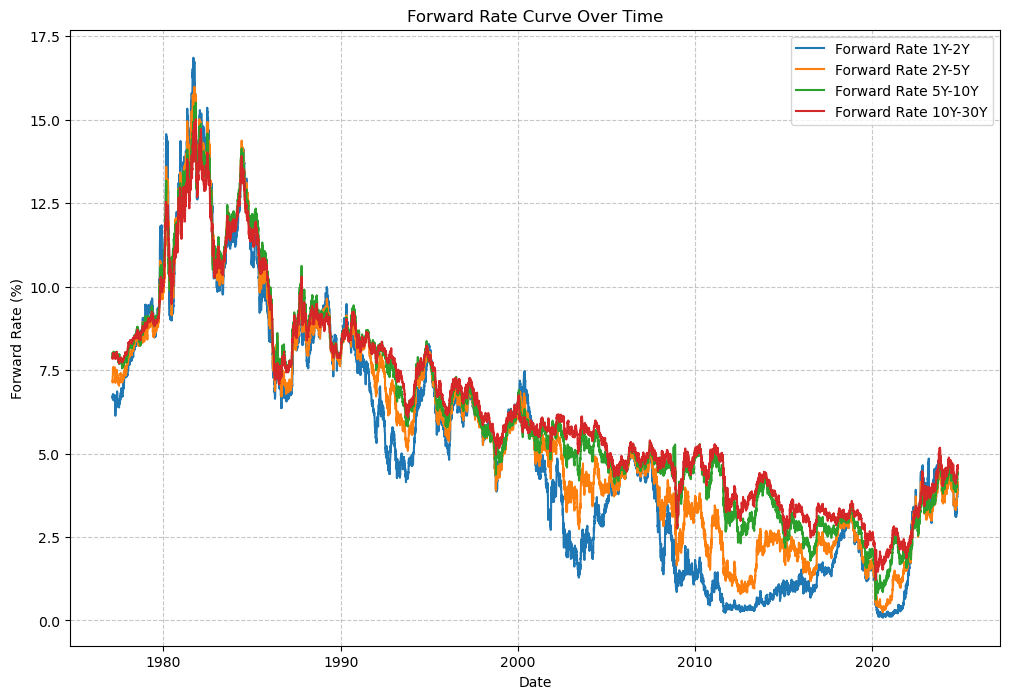

In [16]:
def calculate_forward_rate(yield_curve, t1, t2):
    # Spot rates for maturities t1 and t2
    r_t1 = yield_curve[f"{t1}Y"]
    r_t2 = yield_curve[f"{t2}Y"]
    
    forward_rate = ((1 + r_t2 / 100) ** t2 / (1 + r_t1 / 100) ** t1) ** (1 / (t2 - t1)) - 1
    return forward_rate * 100

forward_curve = pd.DataFrame(index=yc.index)
forward_curve['1Y-2Y'] = calculate_forward_rate(yc, 1, 2)
forward_curve['2Y-5Y'] = calculate_forward_rate(yc, 2, 5)
forward_curve['5Y-10Y'] = calculate_forward_rate(yc, 5, 10)
forward_curve['10Y-30Y'] = calculate_forward_rate(yc, 10, 30)

print("Forward Rate Curve:")
print(forward_curve.head())

plt.figure(figsize=(12, 8))
for column in forward_curve.columns:
    plt.plot(forward_curve.index, forward_curve[column], label=f"Forward Rate {column}")

plt.title("Forward Rate Curve Over Time")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [17]:
forward_curve.tail()

,1Y-2Y,2Y-5Y,5Y-10Y,10Y-30Y
DATE,,,,
2024-10-25,3.930311,4.043342,4.430311,4.640243
2024-10-28,3.960245,4.103334,4.450278,4.655225
2024-10-29,3.930311,4.110000,4.450278,4.640207
2024-10-30,4.020162,4.133334,4.440216,4.590144
2024-10-31,4.050116,4.143334,4.410162,4.565130


# III. Analysis of Yield Curve Movements using PCA

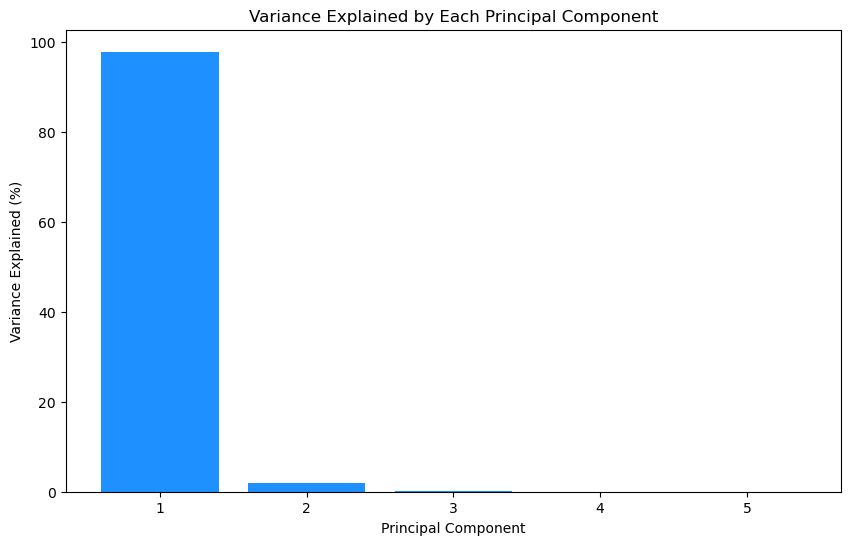

In [18]:
yield_data = yc[['1Y', '2Y', '5Y', '10Y', '30Y']]

scaler = StandardScaler()
yield_data_std = scaler.fit_transform(yield_data)

pca = PCA(n_components=5)
pca.fit(yield_data_std)
yield_pca = pca.transform(yield_data_std)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, color='dodgerblue')
plt.title("Variance Explained by Each Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.show()

As expected, we see that most of the variance has been captured by the first PC. With the rest being captured by 2 and 3.

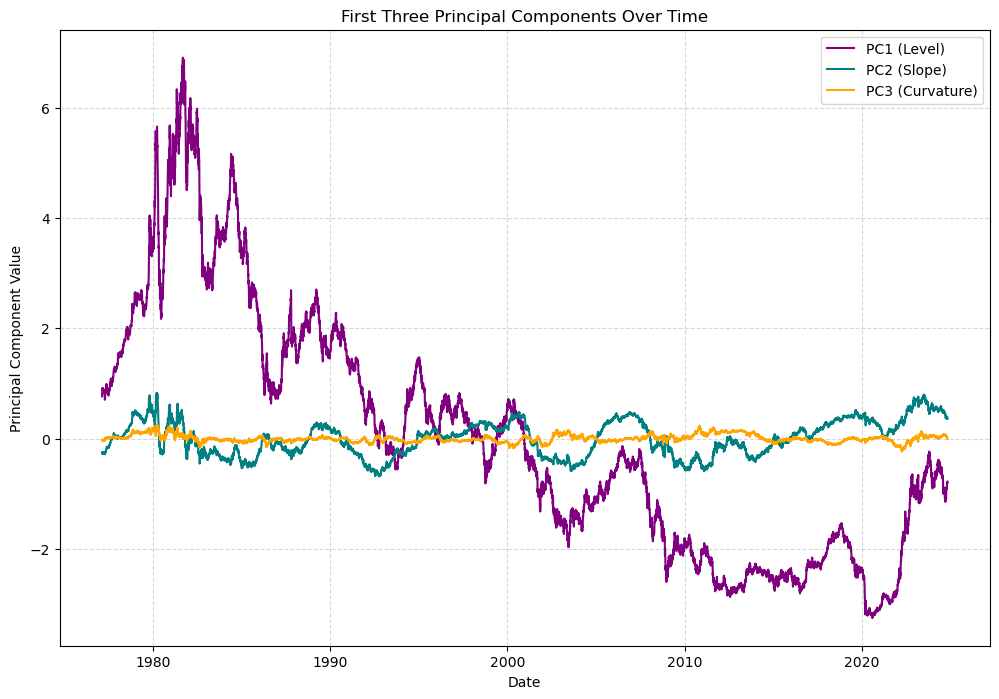

In [19]:
# Convert the PCA components to a DataFrame for further analysis
pca_df = pd.DataFrame(yield_pca, index=yield_data.index, columns=[f'PC{i+1}' for i in range(yield_pca.shape[1])])

plt.figure(figsize=(12, 8))
plt.plot(pca_df.index, pca_df['PC1'], label='PC1 (Level)', color='purple')
plt.plot(pca_df.index, pca_df['PC2'], label='PC2 (Slope)', color='teal')
plt.plot(pca_df.index, pca_df['PC3'], label='PC3 (Curvature)', color='orange')
plt.title("First Three Principal Components Over Time")
plt.xlabel("Date")
plt.ylabel("Principal Component Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The principal components are used to calibrate the volatility structure of the HJM model. This ensures that the stochastic simulation of forward rates reflects historical yield curve dynamics. Each PC is associated with a factor in the HJM model, which influences how forward rates evolve over time.

## i. Incorporating PCA factors for Volatility Calcualtions

In [20]:
# eigenvectors: factor loadings
# eigenvalues: explained variance

# def calculate_volatility(t, T_index, eigenvectors, eigenvalues, n_factors=3):

#     eigenvalues_rescaled = eigenvalues / np.sum(eigenvalues)
#     volatility = 0
#     for i in range(min(n_factors, len(eigenvalues))):
#         # volatility += eigenvectors[i, T_index] * np.sqrt(eigenvalues[i])
#         term = eigenvectors[i, T_index] * np.sqrt(eigenvalues_rescaled[i])
#         volatility += term
#     return volatility

In [21]:
# {np.exp(-0.01 * t)} is the scaling factor/damping term

# def calculate_volatility(t, T_index, eigenvectors, eigenvalues, n_factors=3):
#     volatility = 0
#     for i in range(min(n_factors, len(eigenvalues))):
#         term = eigenvectors[i, T_index] * np.sqrt(eigenvalues[i]) * np.exp(-0.01 * t)
#         volatility += term
#     return volatility

In [22]:
def calculate_volatility(t, T_index, eigenvectors, eigenvalues, n_factors=3, scaling_factor=10):
    volatility = 0
    for i in range(min(n_factors, len(eigenvalues))):
        eigenvalue_rescaled = np.sqrt(eigenvalues[i]) / scaling_factor  # Rescale eigenvalues
        term = eigenvectors[i, T_index] * eigenvalue_rescaled * np.exp(-0.01 * t)
        volatility += term
        # Debugging output
        # print(f"Factor {i + 1}: Eigenvalue = {eigenvalues[i]:.6f}, "
        #       f"Rescaled Eigenvalue = {eigenvalue_rescaled:.6f}, "
        #       f"Eigenvector = {eigenvectors[i, T_index]:.6f}, Term = {term:.6f}")
    return abs(volatility)

# IV: Stochastic Modeling with the HJM Framework

## i. Monte Carlo Simulation

In [51]:
print("Select a random number generation method for the diffusion component:")
print("1: Standard Normal Distribution")
print("2: Uniform Distribution")
print("3: Sobol Sequence")
print("4: Halton Sequence")
print("5: Latin Hypercube Sequence")
user_choice = int(input("Enter your choice (1/2/3/4/5): "))
rng_methods = {
    1: "normal",
    2: "uniform",
    3: "sobol",
    4: "halton",
    5: "lhs",
}
rng_method = rng_methods.get(user_choice, "normal")
print(f"Using RNG Method: {rng_method}")

Select a random number generation method for the diffusion component:
1: Standard Normal Distribution
2: Uniform Distribution
3: Sobol Sequence
4: Halton Sequence
5: Latin Hypercube Sequence
Using RNG Method: sobol


/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


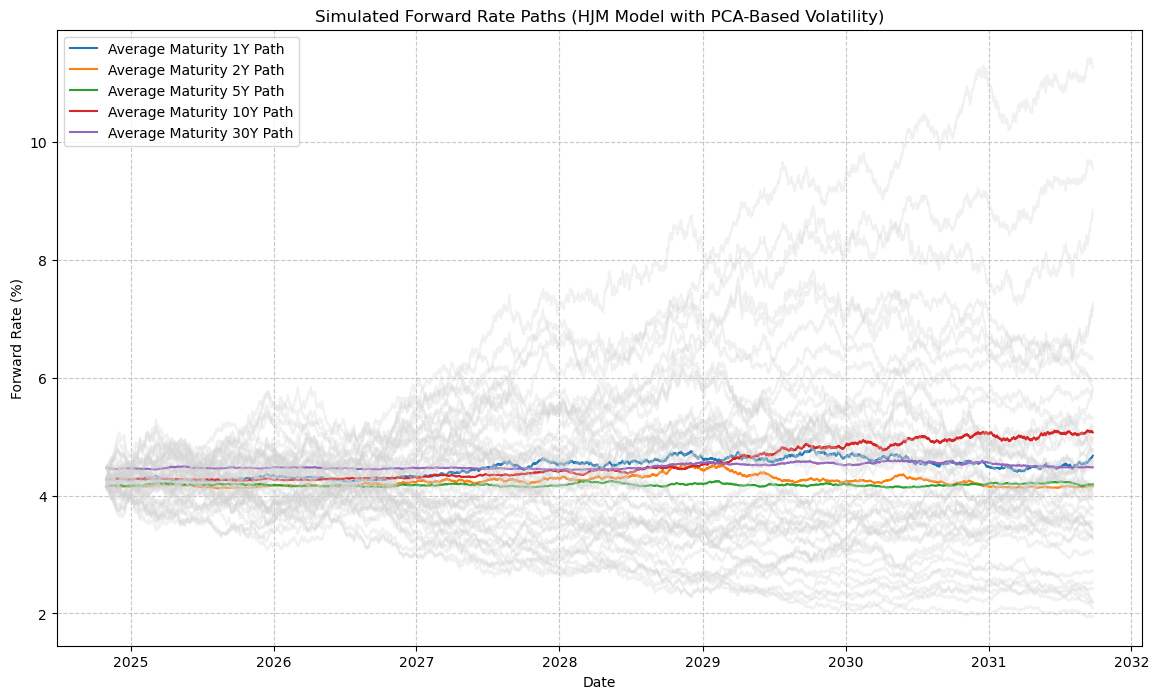

In [52]:
available_maturities = ['1Y', '2Y', '5Y', '10Y', '30Y']
# n_steps = 252  # Daily steps
n_steps = 252  * 10
n_simulations = 10
dt = 1 / 252
initial_forward_rates = yc[available_maturities].iloc[-1].values  # Ensure these are correctly scaled
n_maturities = len(initial_forward_rates)

# Initialize simulated forward rates
simulated_forward_rates = np.zeros((n_steps, n_maturities, n_simulations))
simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]

# Monte Carlo Simulation
for i in range(1, n_steps):
    dW = rng.generate_random_numbers(rng_method, (n_maturities, n_simulations), dt=dt)  # Correct RNG
    for j in range(n_maturities):
        volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
        drift = 0  # No drift in this HJM implementation
        diffusion = volatility * dW[j, :]
        simulated_forward_rates[i, j, :] = simulated_forward_rates[i - 1, j, :] * np.exp(drift * dt + diffusion)

# Plot the results
dates = pd.date_range(start=yc.index[-1], periods=n_steps, freq='D')
simulated_paths = {f'Maturity {m}Y': pd.DataFrame(simulated_forward_rates[:, j, :], index=dates) for j, m in enumerate([1, 2, 5, 10, 30])}

plt.figure(figsize=(14, 8))
for maturity, paths in simulated_paths.items():
    plt.plot(paths.index, paths.mean(axis=1), label=f"Average {maturity} Path")
    for path in paths.columns:
        plt.plot(paths.index, paths[path], color='lightgray', alpha=0.3)

plt.title("Simulated Forward Rate Paths (HJM Model with PCA-Based Volatility)")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [25]:
# Debugging Initial Forward Rates
print("Initial Forward Rates (from Yield Curve):", initial_forward_rates)

# Debugging Volatility
for j in range(n_maturities):
    print(f"Volatility for Maturity {j+1}Y at Step 1: {calculate_volatility(dt, j, pca.components_, pca.explained_variance_)}")

# Debugging Drift and Diffusion
for i in range(1, n_steps):
    dW = rng.generate_random_numbers("normal", (n_maturities, n_simulations), dt=dt)
    for j in range(n_maturities):
        volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
        drift = 0  # Drift term is set to zero in HJM
        diffusion = volatility * dW[j, :]
        print(f"Step {i}, Maturity {j+1}Y: Drift = {drift}, Diffusion = {np.mean(diffusion):.6f}")
    break  # Check only the first time step

Initial Forward Rates (from Yield Curve): [4.27 4.16 4.15 4.28 4.47]
Volatility for Maturity 1Y at Step 1: 0.12124747081113599
Volatility for Maturity 2Y at Step 1: 0.10945538597405328
Volatility for Maturity 3Y at Step 1: 0.09434825514360755
Volatility for Maturity 4Y at Step 1: 0.08732657934608619
Volatility for Maturity 5Y at Step 1: 0.08236724979434282
Step 1, Maturity 1Y: Drift = 0, Diffusion = -0.000814
Step 1, Maturity 2Y: Drift = 0, Diffusion = 0.000838
Step 1, Maturity 3Y: Drift = 0, Diffusion = 0.001931
Step 1, Maturity 4Y: Drift = 0, Diffusion = -0.002814
Step 1, Maturity 5Y: Drift = 0, Diffusion = -0.003312


In [26]:
print("Simulated Forward Rates Shape:", simulated_forward_rates.shape)

Simulated Forward Rates Shape: (2520, 5, 10)


## ii. Volatility validation

Interpretation of Results

	1.	Small Decay Over Time: The percentage change in volatility (-1.93%) is consistent across maturities. This aligns with the behavior expected from the model, assuming a slight exponential decay in volatility as time progresses.
	2.	Standard Deviation Insight: The standard deviation values are relatively low, suggesting stability in the volatility estimates over the simulation horizon.

## ii. Validation of RNG Schemes

/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


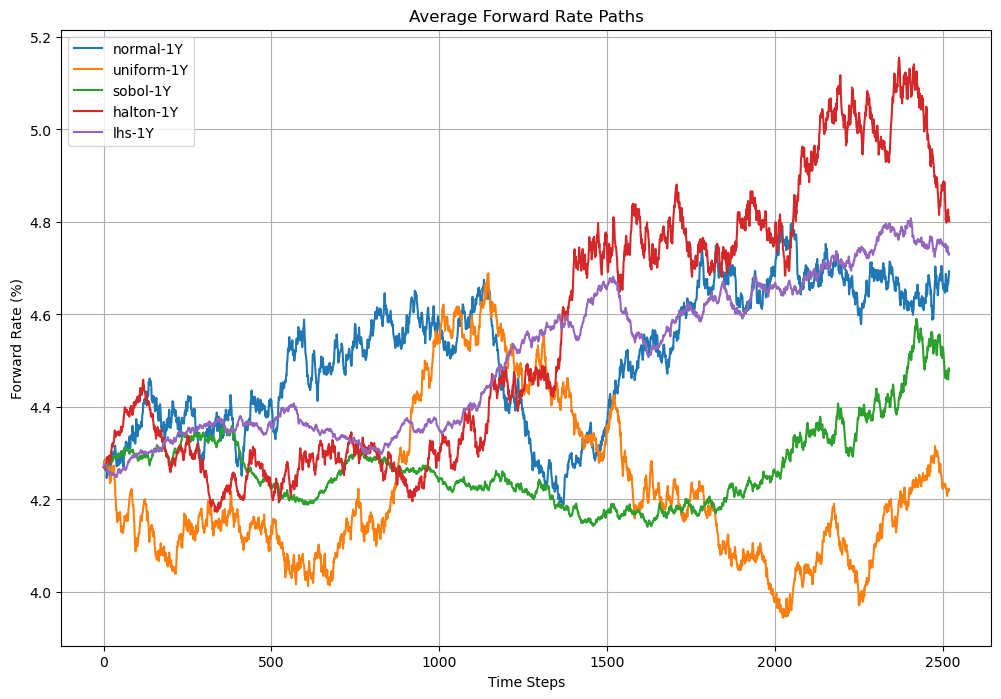

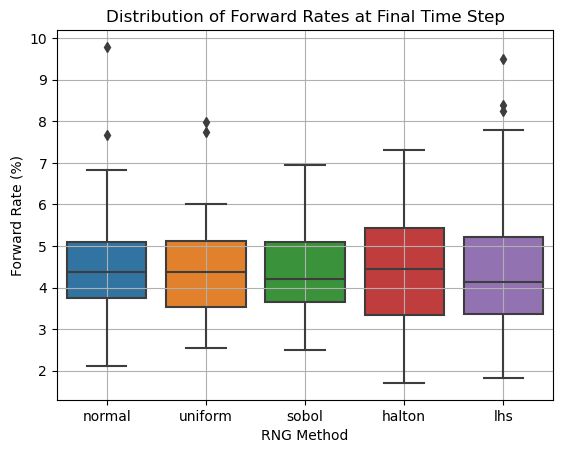

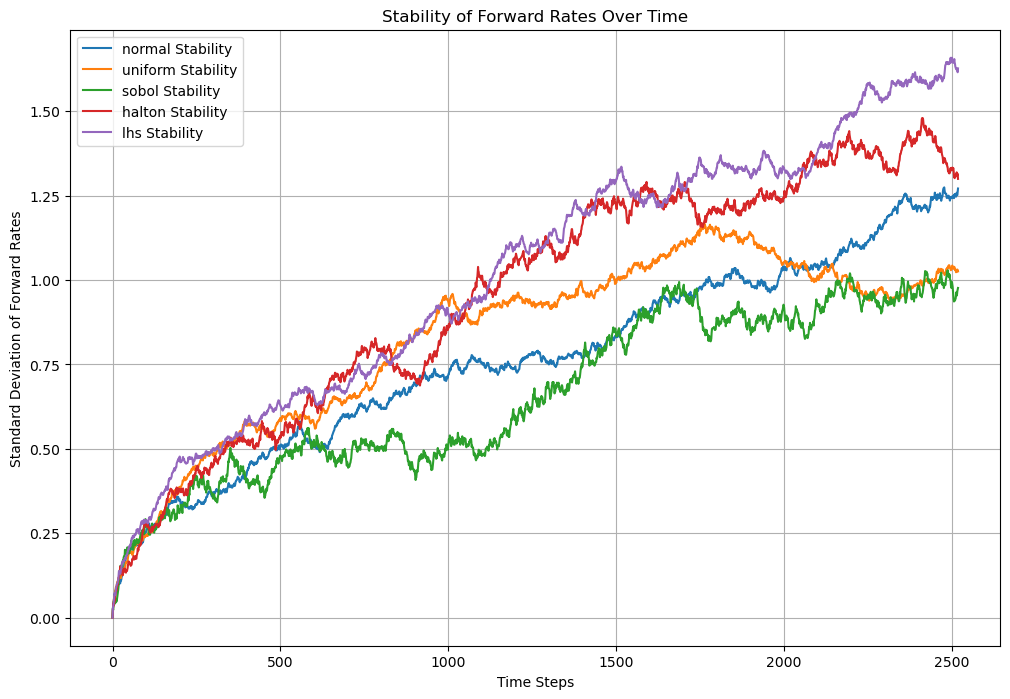

         Mean (Final Step)  Std Dev (Final Step)  Min (Final Step)  \
normal            4.570394              1.271227          2.109345   
uniform           4.442441              1.025804          2.534767   
sobol             4.428368              0.976701          2.495552   
halton            4.447418              1.299795          1.706112   
lhs               4.565475              1.626920          1.826339   

         Max (Final Step)  Computation Time (s)  
normal           9.787676              0.105579  
uniform          7.992567              0.267056  
sobol            6.947170              0.737389  
halton           7.311219              1.007774  
lhs              9.486483              1.157494  


In [27]:
rng_methods = ["normal", "uniform", "sobol", "halton", "lhs"]
forward_rate_results = {}

for method in rng_methods:
    start_time = time.time()
    simulated_forward_rates = np.zeros((n_steps, n_maturities, n_simulations))
    simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]

    for i in range(1, n_steps):
        dW = rng.generate_random_numbers(method, (n_maturities, n_simulations), dt=dt)
        for j in range(n_maturities):
            volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
            diffusion = volatility * dW[j, :]
            simulated_forward_rates[i, j, :] = simulated_forward_rates[i - 1, j, :] * np.exp(diffusion)

    end_time = time.time()
    forward_rate_results[method] = {
        "rates": simulated_forward_rates,
        "time": end_time - start_time
    }

# Metrics: Mean, Std Dev, Range
metrics = {}
for method, results in forward_rate_results.items():
    rates = results["rates"]
    mean_rates = np.mean(rates, axis=2)
    std_rates = np.std(rates, axis=2)
    min_rates = np.min(rates, axis=2)
    max_rates = np.max(rates, axis=2)
    metrics[method] = {
        "mean": mean_rates,
        "std": std_rates,
        "min": min_rates,
        "max": max_rates,
        "time": results["time"]
    }

# Visualization: Average Forward Rate Paths
plt.figure(figsize=(12, 8))
for method in rng_methods:
    avg_path = np.mean(forward_rate_results[method]["rates"], axis=2)
    plt.plot(avg_path[:, 0], label=f"{method}-1Y")  # Example for 1Y maturity
plt.title("Average Forward Rate Paths")
plt.xlabel("Time Steps")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid()
plt.show()

# Visualization: Boxplots
final_step_rates = {method: results["rates"][-1, :, :].flatten() for method, results in forward_rate_results.items()}
df_boxplot = pd.DataFrame(final_step_rates)
sns.boxplot(data=df_boxplot)
plt.title("Distribution of Forward Rates at Final Time Step")
plt.ylabel("Forward Rate (%)")
plt.xlabel("RNG Method")
plt.grid()
plt.show()

# Visualization: Stability
plt.figure(figsize=(12, 8))
for method in rng_methods:
    std_over_time = np.std(forward_rate_results[method]["rates"], axis=2)
    plt.plot(np.mean(std_over_time, axis=1), label=f"{method} Stability")
plt.title("Stability of Forward Rates Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Standard Deviation of Forward Rates")
plt.legend()
plt.grid()
plt.show()

# Summary Table
summary_table = pd.DataFrame({method: {"Mean (Final Step)": np.mean(metrics[method]["mean"][-1]),
                                       "Std Dev (Final Step)": np.mean(metrics[method]["std"][-1]),
                                       "Min (Final Step)": np.min(metrics[method]["min"][-1]),
                                       "Max (Final Step)": np.max(metrics[method]["max"][-1]),
                                       "Computation Time (s)": metrics[method]["time"]}
                               for method in rng_methods}).T
print(summary_table)

# V. Pricing IR Derivatives

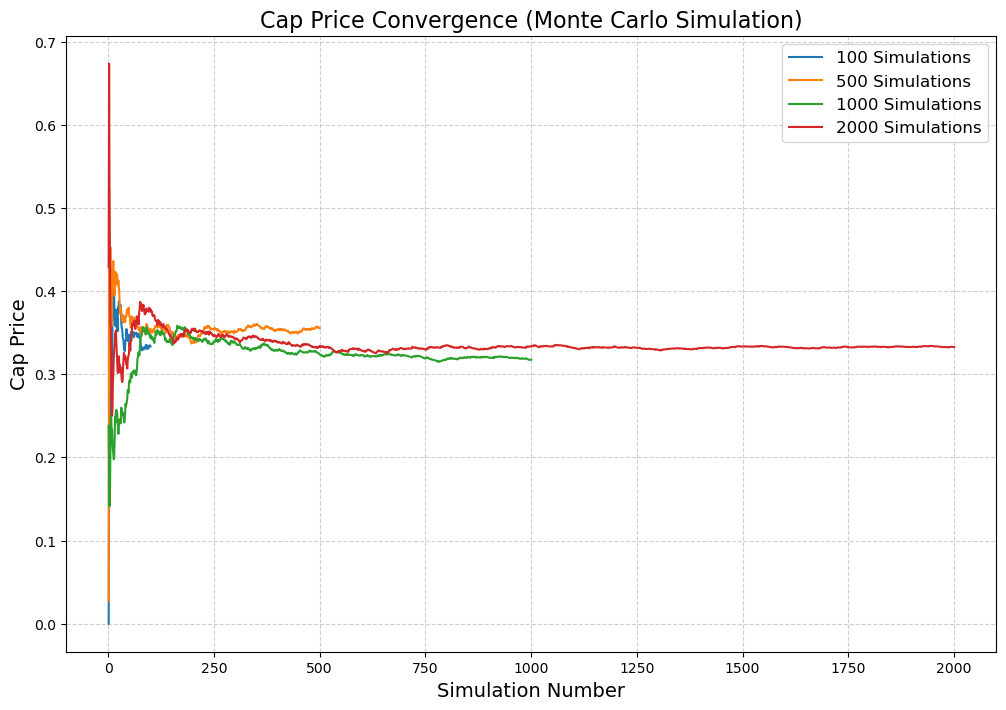

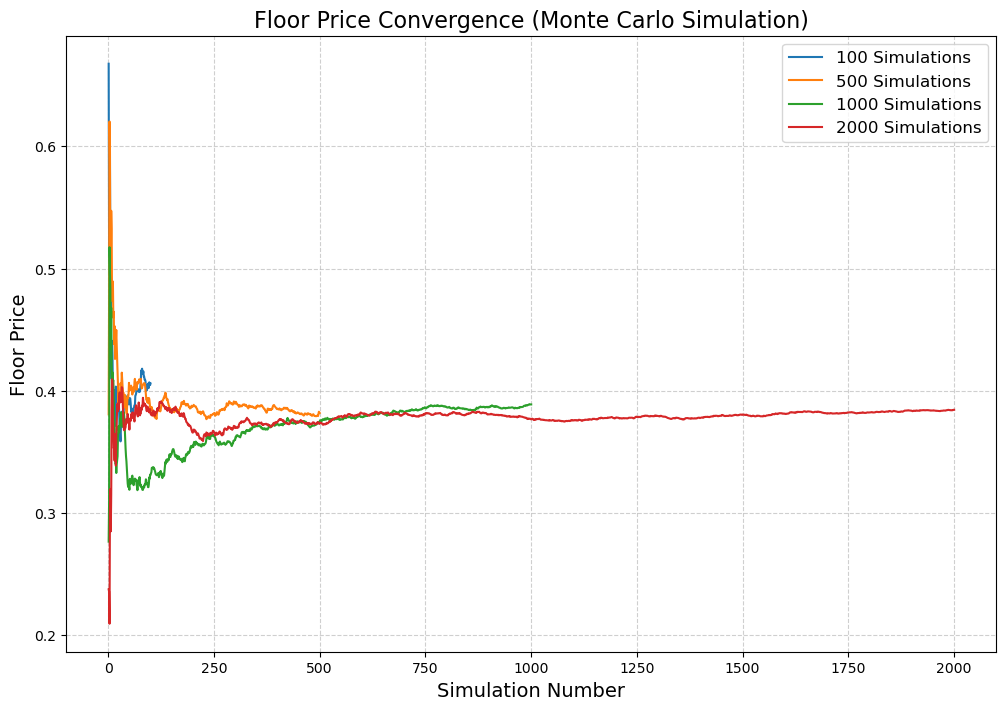

Cap Prices Convergence Results:
100 Simulations: [0.3313388056476696, 0.3301253590207317, 0.3317307329002047, 0.3342751970142549, 0.3311199037118151, 0.3325772572465862, 0.3344968250508023, 0.3344684129626563, 0.334676493194013, 0.3334282048286603]
500 Simulations: [0.35608957425986737, 0.3570574598473218, 0.35658574498094026, 0.35604355237852, 0.356947162009567, 0.3570167013054099, 0.35629835784201874, 0.35558289929213516, 0.3550383556579499, 0.35513077071477106]
1000 Simulations: [0.31825435227165744, 0.3180546445978667, 0.3177406659921724, 0.3174819266098968, 0.3172766262206595, 0.31731092607218314, 0.3174179069331343, 0.3172721318663165, 0.3171994769257773, 0.3176297575902383]
2000 Simulations: [0.33299266360581353, 0.3329450965821585, 0.3330017802509599, 0.3330088376011477, 0.3329909326368742, 0.33283884143138914, 0.3327130589762214, 0.332611355786304, 0.3327488020076289, 0.332681854499144]

Floor Prices Convergence Results:
100 Simulations: [0.40139512803156707, 0.401195088903755

In [ ]:
# Parameters
sofr_discount_factors = sofr['Discount_Factor']
expiry = 5  # Expiry in years
n_simulations_list = [100, 500, 1000, 2000] 
#rng_method = "normal"  # Example RNG method, replace with the user's choice
dt = 1 / 252  # Time step
expiry_index = int(expiry / dt) - 1  # Convert expiry to index (assuming daily steps)
#strike = 0.056  # Example strike rate for cap/floor
strike = simulated_forward_rates[expiry_index, :, :].mean() + 0.005

def price_cap(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]  # Extract rates at expiry
    payoffs = np.maximum(forward_rates - strike, 0).mean(axis=0)  # Average across simulations
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    cap_price = payoffs * discount_factor
    return cap_price.mean()  # Average over simulations

def price_floor(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]  # Shape: (n_maturities, n_simulations)
    payoffs = np.maximum(strike - forward_rates, 0)  # Floor payoff: max(K - F, 0)
    average_payoffs = payoffs.mean(axis=0)  # Shape: (n_simulations,)
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    floor_price = average_payoffs * discount_factor
    return floor_price.mean()  # Average over all simulations

# Initialize storage for convergence results
cap_convergence = {n_sim: [] for n_sim in n_simulations_list}
floor_convergence = {n_sim: [] for n_sim in n_simulations_list}
final_prices = {"Caps": {}, "Floors": {}} 

# Monte Carlo Simulation for Convergence
for n_simulations in n_simulations_list:
    simulated_forward_rates = np.zeros((expiry_index + 1, 5, n_simulations))
    simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]
    for t in range(1, expiry_index + 1):
        dW = rng.generate_random_numbers(rng_method, (5, n_simulations), dt=dt)
        for j in range(5):
            volatility = calculate_volatility(t * dt, j, pca.components_, pca.explained_variance_)
            diffusion = volatility * dW[j, :]
            simulated_forward_rates[t, j, :] = simulated_forward_rates[t - 1, j, :] * np.exp(diffusion)

    for sim in range(1, n_simulations + 1):
        cap_convergence[n_simulations].append(
            price_cap(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
        )
        floor_convergence[n_simulations].append(
            price_floor(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
        )

    final_prices["Caps"][n_simulations] = cap_convergence[n_simulations][-1]
    final_prices["Floors"][n_simulations] = floor_convergence[n_simulations][-1]

# Plotting Cap Convergence Results
plt.figure(figsize=(12, 8))
for n_simulations in n_simulations_list:
    plt.plot(range(1, n_simulations + 1), cap_convergence[n_simulations], label=f"{n_simulations} Simulations")
plt.title("Cap Price Convergence (Monte Carlo Simulation)", fontsize=16)
plt.xlabel("Simulation Number", fontsize=14)
plt.ylabel("Cap Price", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

# Plotting Floor Convergence Results
plt.figure(figsize=(12, 8))
for n_simulations in n_simulations_list:
    plt.plot(range(1, n_simulations + 1), floor_convergence[n_simulations], label=f"{n_simulations} Simulations")
plt.title("Floor Price Convergence (Monte Carlo Simulation)", fontsize=16)
plt.xlabel("Simulation Number", fontsize=14)
plt.ylabel("Floor Price", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

# Display numerical results for caps
print("Cap Prices Convergence Results:")
for n_simulations in n_simulations_list:
    print(f"{n_simulations} Simulations: {cap_convergence[n_simulations][-10:]}")

# Display numerical results for floors
print("\nFloor Prices Convergence Results:")
for n_simulations in n_simulations_list:
    print(f"{n_simulations} Simulations: {floor_convergence[n_simulations][-10:]}")

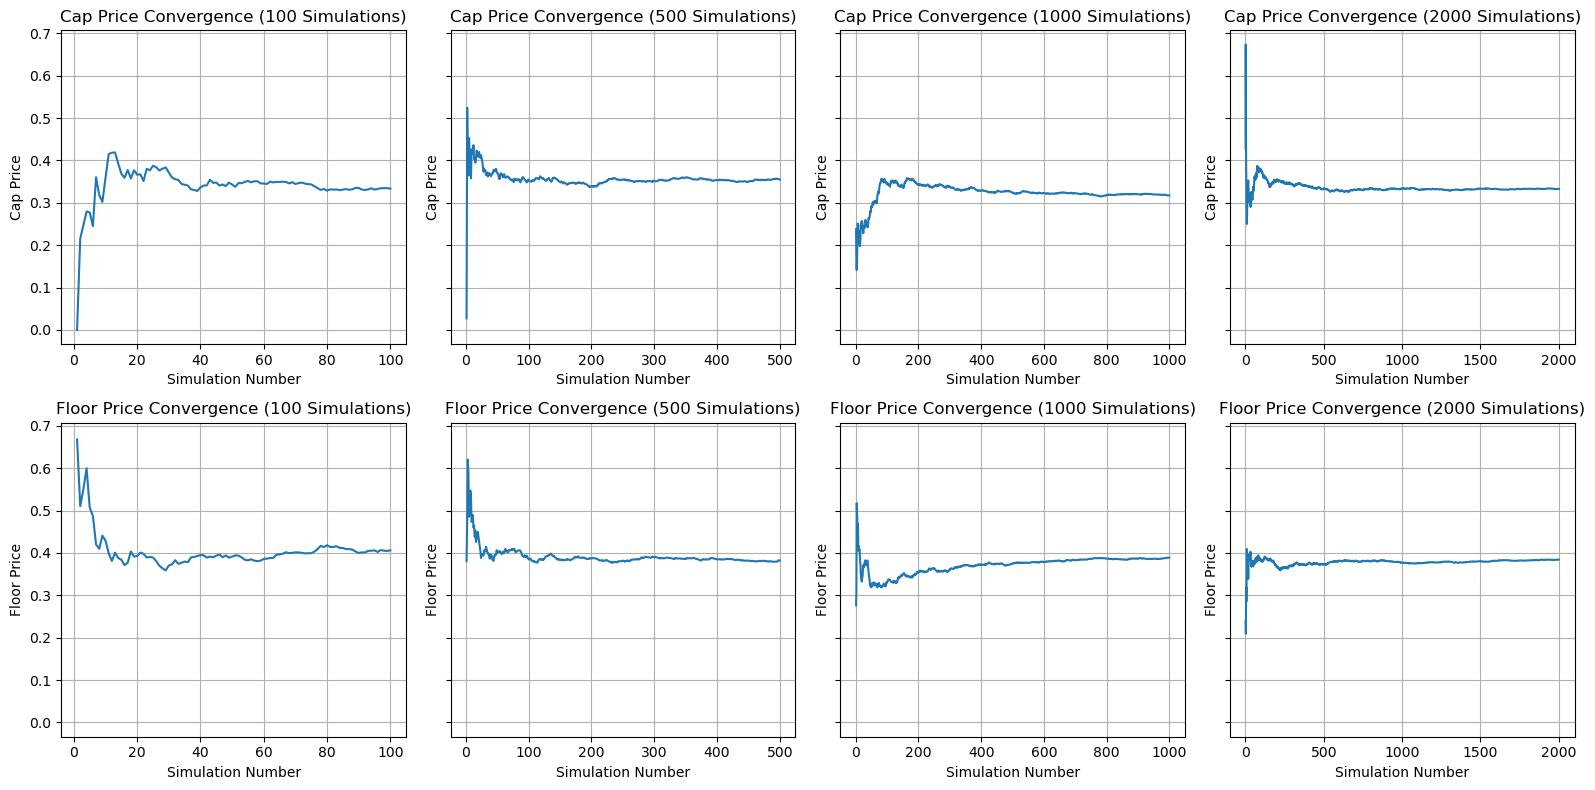


Final Monte Carlo Prices:

Cap Prices Convergence Results:
   Number of Simulations  Cap Price
0                    100   0.333428
1                    500   0.355131
2                   1000   0.317630
3                   2000   0.332682

Floor Prices Convergence Results:
   Number of Simulations  Floor Price
0                    100     0.405952
1                    500     0.381857
2                   1000     0.388809
3                   2000     0.384430


In [29]:
# Plotting Convergence Results
fig, axs = plt.subplots(2, len(n_simulations_list), figsize=(16, 8), sharey=True)
for i, n_simulations in enumerate(n_simulations_list):
    axs[0, i].plot(range(1, n_simulations + 1), cap_convergence[n_simulations], label="Cap Convergence")
    axs[0, i].set_title(f"Cap Price Convergence ({n_simulations} Simulations)")
    axs[0, i].set_xlabel("Simulation Number")
    axs[0, i].set_ylabel("Cap Price")
    axs[0, i].grid()

    axs[1, i].plot(range(1, n_simulations + 1), floor_convergence[n_simulations], label="Floor Convergence")
    axs[1, i].set_title(f"Floor Price Convergence ({n_simulations} Simulations)")
    axs[1, i].set_xlabel("Simulation Number")
    axs[1, i].set_ylabel("Floor Price")
    axs[1, i].grid()

plt.tight_layout()
plt.show()

# Display Final Prices Neatly
print("\nFinal Monte Carlo Prices:")
cap_df = pd.DataFrame.from_dict(final_prices["Caps"], orient="index", columns=["Cap Price"]).reset_index()
cap_df.rename(columns={"index": "Number of Simulations"}, inplace=True)
floor_df = pd.DataFrame.from_dict(final_prices["Floors"], orient="index", columns=["Floor Price"]).reset_index()
floor_df.rename(columns={"index": "Number of Simulations"}, inplace=True)

# Display Cap Prices
print("\nCap Prices Convergence Results:")
print(cap_df)

# Display Floor Prices
print("\nFloor Prices Convergence Results:")
print(floor_df)

# VI. Variance Reduction

In [30]:
def standard_mc(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    """
    Standard Monte Carlo pricing without variance reduction.
    """
    # Extract forward rates at expiry
    forward_rates = simulated_forward_rates[expiry_index, :, :]  # Shape: (n_maturities, n_simulations)
    # Calculate payoffs for a cap
    payoffs = np.maximum(forward_rates - strike, 0).mean(axis=0)  # Average across maturities for each simulation
    # Apply SOFR discount factor
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    cap_price = payoffs * discount_factor
    return cap_price.mean()  # Average across all simulations

In [31]:
def antithetic_variates(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    """
    Monte Carlo pricing with Antithetic Variates.
    """
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    antithetic_rates = -simulated_forward_rates[expiry_index, :, :]  # Generate antithetic paths
    payoffs = np.maximum(forward_rates - strike, 0)  # Standard path payoffs
    antithetic_payoffs = np.maximum(antithetic_rates - strike, 0)  # Antithetic path payoffs
    combined_payoffs = (payoffs + antithetic_payoffs) / 2  # Average payoffs
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    return (combined_payoffs.mean() * discount_factor)  # Return adjusted price

In [32]:
def control_variates(simulated_forward_rates, strike, expiry_index, sofr_discount_factors, analytical_price):
    """
    Monte Carlo pricing with Control Variates.
    """
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    payoffs = np.maximum(forward_rates - strike, 0).mean(axis=0)  # Average across simulations
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    estimated_price = payoffs * discount_factor

    # Ensure analytical_price is scalar
    if np.isscalar(analytical_price):
        adjustment = analytical_price - np.mean(estimated_price)  # Adjust by the difference in means
    else:
        raise ValueError("Analytical price should be a scalar value.")
    
    return np.mean(estimated_price) + adjustment

/var/folders/xg/dhj8tpr14lqgyb0stf1z1sm40000gn/T/ipykernel_7247/3199070413.py:40: RuntimeWarning: invalid value encountered in scalar divide
  control_adjustment = -cov / np.var(control_variate)


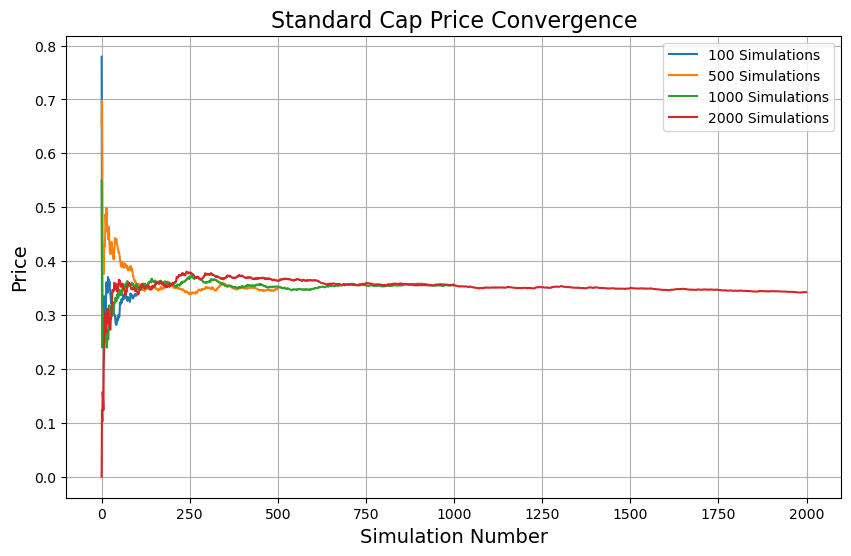

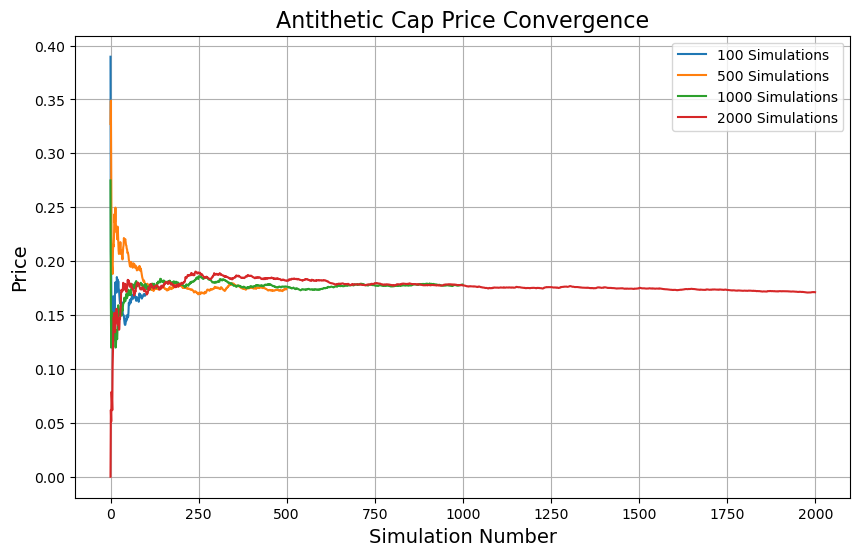

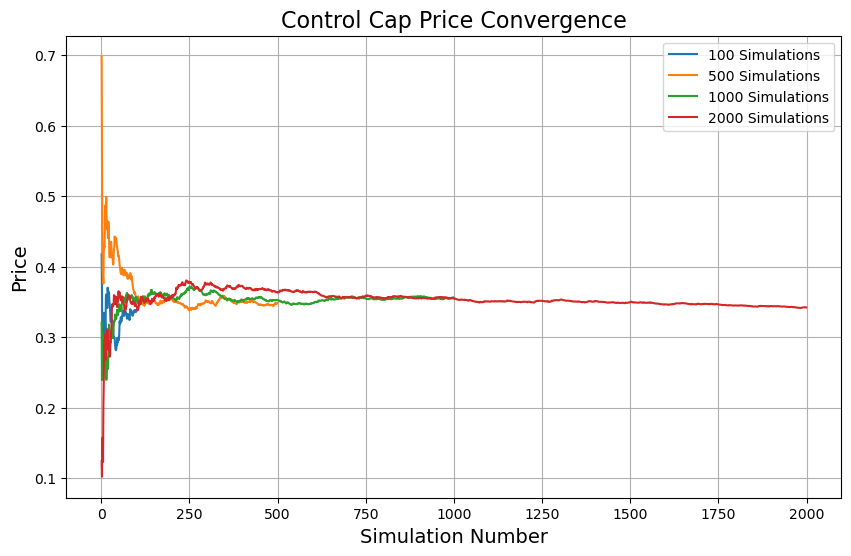

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sofr_discount_factors = sofr['Discount_Factor']
expiry = 5  # Expiry in years
n_simulations_list = [100, 500, 1000, 2000]
dt = 1 / 252  # Time step
expiry_index = int(expiry / dt) - 1  # Convert expiry to index (assuming daily steps)
strike = simulated_forward_rates[expiry_index, :, :].mean() + 0.005

# Functions for pricing
def price_cap(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]  # Extract rates at expiry
    payoffs = np.maximum(forward_rates - strike, 0).mean(axis=0)  # Average across simulations
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    cap_price = payoffs * discount_factor
    return cap_price.mean()  # Average over simulations

# Antithetic variates method
def price_antithetic(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    antithetic_rates = 1 - simulated_forward_rates[expiry_index, :, :]
    forward_rates_combined = np.concatenate((forward_rates, antithetic_rates), axis=1)
    payoffs = np.maximum(forward_rates_combined - strike, 0).mean(axis=0)
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    cap_price = payoffs * discount_factor
    return cap_price.mean()

# Control variate method
def price_control_variates(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    payoffs = np.maximum(forward_rates - strike, 0)
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    mc_price = payoffs.mean(axis=0) * discount_factor

    control_variate = forward_rates.mean(axis=0)  # Example control variate
    analytical_control_price = control_variate.mean()
    cov = np.cov(mc_price, control_variate, bias=True)[0, 1]
    control_adjustment = -cov / np.var(control_variate)
    adjusted_price = mc_price + control_adjustment * (control_variate - analytical_control_price)
    return adjusted_price.mean()

# Simulate paths and calculate prices
convergence_results = {"Standard": {}, "Antithetic": {}, "Control": {}}
for n_simulations in n_simulations_list:
    simulated_forward_rates = generate_simulated_paths(n_simulations, expiry_index)

    for sim in range(1, n_simulations + 1):
        # Standard Monte Carlo
        standard_price = price_cap(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
        convergence_results["Standard"].setdefault(n_simulations, []).append(standard_price)

        # Antithetic Variates
        antithetic_price = price_antithetic(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
        convergence_results["Antithetic"].setdefault(n_simulations, []).append(antithetic_price)

        # Control Variates
        control_price = price_control_variates(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
        convergence_results["Control"].setdefault(n_simulations, []).append(control_price)

# Plotting results
methods = ["Standard", "Antithetic", "Control"]
for method in methods:
    plt.figure(figsize=(10, 6))
    for n_simulations in n_simulations_list:
        plt.plot(convergence_results[method][n_simulations], label=f"{n_simulations} Simulations")
    plt.title(f"{method} Cap Price Convergence", fontsize=16)
    plt.xlabel("Simulation Number", fontsize=14)
    plt.ylabel("Price", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

In [37]:
reference_price = convergence_results["Standard"][2000][-1]

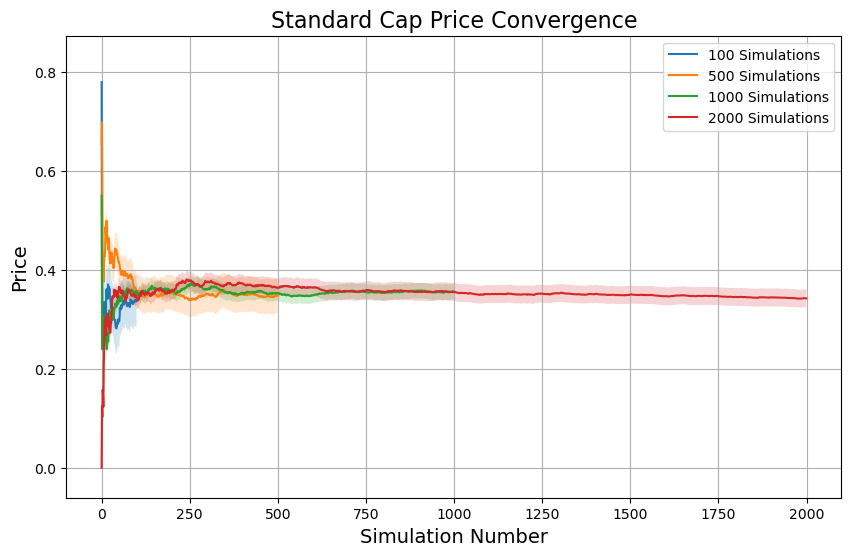

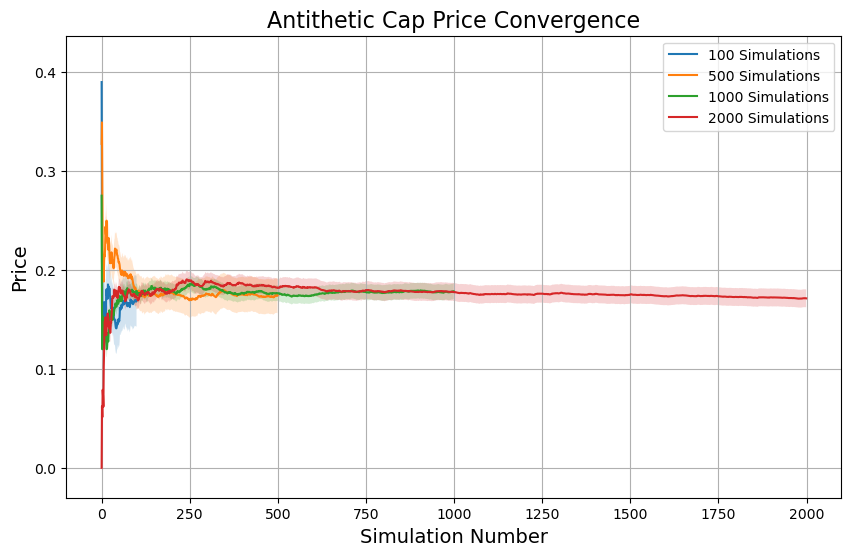

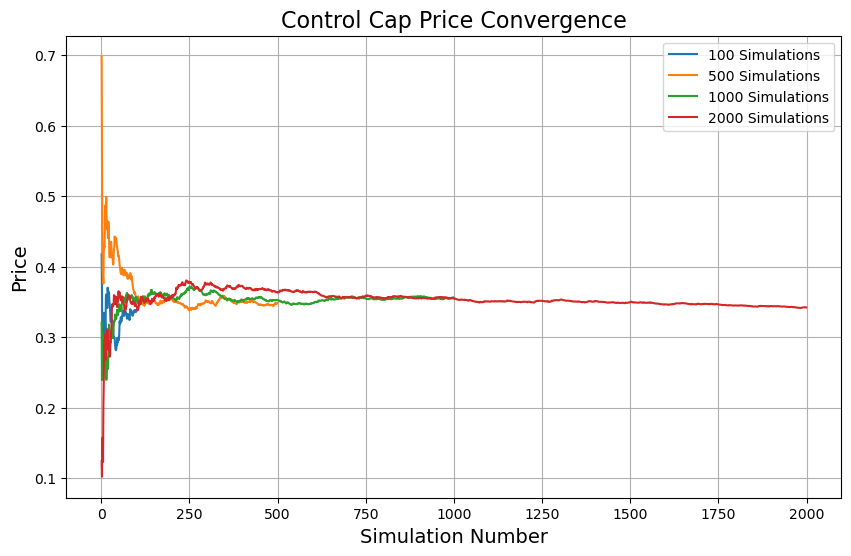

In [38]:
# Example: Plotting convergence with error bands
for method in methods:
    plt.figure(figsize=(10, 6))
    for n_simulations in n_simulations_list:
        prices = np.array(convergence_results[method][n_simulations])
        std_dev = np.std(prices)
        plt.plot(prices, label=f"{n_simulations} Simulations")
        plt.fill_between(range(len(prices)), prices - std_dev, prices + std_dev, alpha=0.2)
    plt.title(f"{method} Cap Price Convergence", fontsize=16)
    plt.xlabel("Simulation Number", fontsize=14)
    plt.ylabel("Price", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
expiry = 5  # Expiry in years
n_simulations_list = [100, 500, 1000, 2000]
dt = 1 / 252  # Time step
expiry_index = int(expiry / dt) - 1  # Convert expiry to index
strike = 0.056  # Example strike rate for cap/floor

# Function to calculate cap prices
def price_cap(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]  # Extract rates at expiry
    payoffs = np.maximum(forward_rates - strike, 0)  # Average across simulations
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    cap_price = (payoffs.mean(axis=0)) * discount_factor
    return cap_price.mean()  # Average over simulations

# Function for generating simulated paths
def generate_simulated_paths(n_simulations, expiry_index, initial_forward_rates, rng, volatility_fn, pca, sofr_discount_factors):
    simulated_forward_rates = np.zeros((expiry_index + 1, 5, n_simulations))
    simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]
    for t in range(1, expiry_index + 1):
        dW = rng.generate_random_numbers("normal", (5, n_simulations), dt=dt)  # Random numbers
        for j in range(5):
            volatility = volatility_fn(t * dt, j, pca.components_, pca.explained_variance_)
            diffusion = volatility * dW[j, :]
            simulated_forward_rates[t, j, :] = simulated_forward_rates[t - 1, j, :] * np.exp(diffusion)
    return simulated_forward_rates

# Function for control variates
def control_variates(simulated_forward_rates, strike, expiry_index, sofr_discount_factors):
    forward_rates = simulated_forward_rates[expiry_index, :, :]
    payoffs = np.maximum(forward_rates - strike, 0)  # Payoff for cap
    discount_factor = sofr_discount_factors.iloc[expiry_index]
    mc_price = payoffs.mean(axis=0) * discount_factor  # Monte Carlo price

    # Compute adjustment using analytical price
    control_variate = forward_rates.mean(axis=0)  # Example control variate
    cov = np.cov(mc_price, control_variate, bias=True)[0, 1]
    control_adjustment = -cov / np.var(control_variate)
    return mc_price + control_adjustment * (control_variate - np.mean(control_variate))

# Monte Carlo simulations and variance analysis
convergence_results = {"Standard": {}, "Antithetic": {}, "Control": {}}
variance_results = {"Standard": {}, "Antithetic": {}, "Control": {}}

for n_simulations in n_simulations_list:
    simulated_forward_rates = generate_simulated_paths(
        n_simulations, expiry_index, initial_forward_rates, rng, calculate_volatility, pca, sofr_discount_factors
    )

    for method in ["Standard", "Antithetic", "Control"]:
        prices = []
        for sim in range(1, n_simulations + 1):
            if method == "Standard":
                price = price_cap(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
            elif method == "Antithetic":
                antithetic_rates = 1 - simulated_forward_rates[:, :, :sim]
                price = price_cap(antithetic_rates, strike, expiry_index, sofr_discount_factors)
            elif method == "Control":
                price = control_variates(simulated_forward_rates[:, :, :sim], strike, expiry_index, sofr_discount_factors)
            prices.append(price)
        convergence_results[method][n_simulations] = prices
        variance_results[method][n_simulations] = np.var(prices)

# Calculate variance reduction rates
rate_of_reduction = {method: {} for method in ["Antithetic", "Control"]}
for method in ["Antithetic", "Control"]:
    for n_simulations in n_simulations_list:
        std_variance = variance_results["Standard"][n_simulations]
        method_variance = variance_results[method][n_simulations]
        rate_of_reduction[method][n_simulations] = method_variance / std_variance

# Print numerical results
print("Variance Results:")
for method in ["Standard", "Antithetic", "Control"]:
    print(f"{method} Method:")
    for n_simulations in n_simulations_list:
        print(f"  {n_simulations} Simulations: Variance = {variance_results[method][n_simulations]:.6f}")
    print()

print("Rate of Variance Reduction:")
for method in ["Antithetic", "Control"]:
    print(f"{method} Method:")
    for n_simulations in n_simulations_list:
        print(f"  {n_simulations} Simulations: Rate = {rate_of_reduction[method][n_simulations]:.2f}x")
    print()

# Plotting variance comparison
plt.figure(figsize=(10, 6))
for method in ["Standard", "Antithetic", "Control"]:
    variances = [variance_results[method][n] for n in n_simulations_list]
    plt.plot(n_simulations_list, variances, marker='o', label=f"{method} Variance")

plt.xscale("log")
plt.yscale("log")
plt.title("Variance vs. Number of Simulations", fontsize=16)
plt.xlabel("Number of Simulations (log scale)", fontsize=14)
plt.ylabel("Variance (log scale)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

/var/folders/xg/dhj8tpr14lqgyb0stf1z1sm40000gn/T/ipykernel_7247/605635743.py:41: RuntimeWarning: invalid value encountered in scalar divide
  control_adjustment = -cov / np.var(control_variate)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.